In [17]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
from src.ptp.models.gan_3d.gan3d import Generator
from src.ptp.models.gan_3d.discriminator import Discriminator
from src.ptp.models.gan_3d.gan3d import GAN3D
from src.ptp.models.utils import num_trainable_params
from src.ptp.evaluation.visualization import visualize_slices, visualize_volumes, plot_slice
from src.ptp.models.losses import tce_loss
from pathlib import Path
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import nibabel as nib  
import numpy as np

from monai.data import MetaTensor
import pytorch_lightning as pl
import torch
from torch import nn
import os

In [20]:
DATA_DIR = Path('../data/generated_part1_nii_gz')
TARGET_DATA_DIR = DATA_DIR
INPUT_DIR = Path('../data')
MODELS_DIR = INPUT_DIR / 'models'
TRAINING_DIR = INPUT_DIR / 'training'
os.makedirs(TRAINING_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

In [21]:
percentile = 5
n_critic = 5  # for training more k steps about Discriminator

In [10]:
gan = GAN3D(target_data_dir=TARGET_DATA_DIR, percentile=percentile, n_critic=n_critic, recon_loss=tce_loss)

In [11]:
print(f"Generator size is {num_trainable_params(gan.G)}")
print(f"Discriminator size is {num_trainable_params(gan.D)}")

Generator size is 587011
Discriminator size is 410096


In [12]:
gan.prepare_data()
train_loader = gan.train_dataloader()

Target stats: (0.016611231657773118, -1.0, 1.0)
Image stats: (0.16984386961308984, -0.9999991655349731, 1.0)


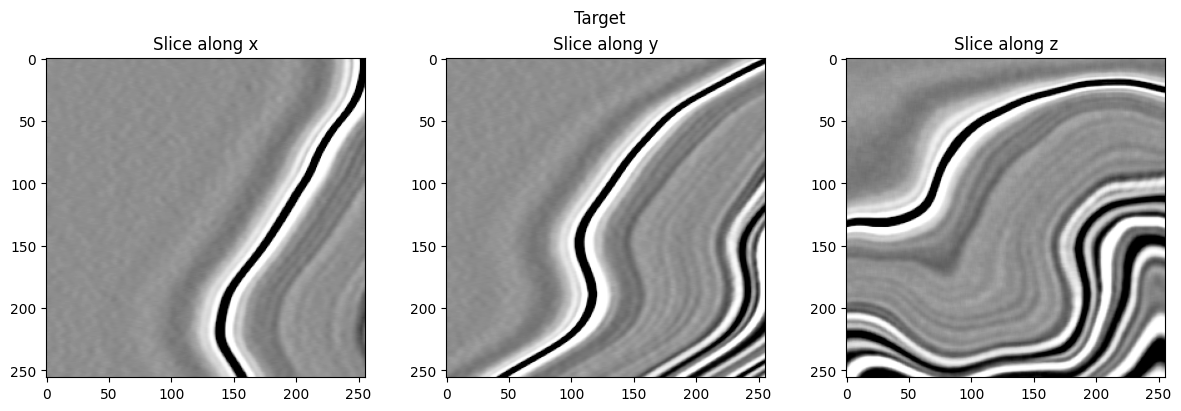

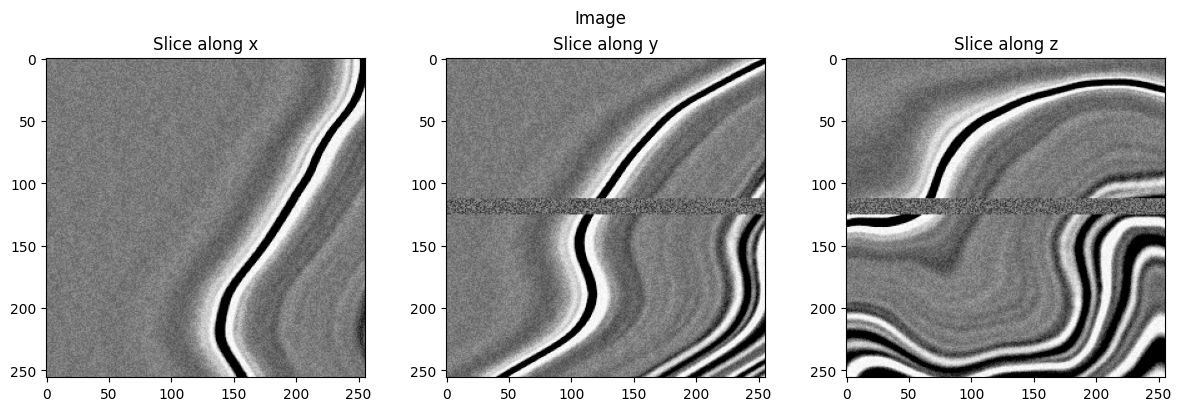

In [13]:
x, y, z = 50, 150, 200
for i, batch in enumerate(train_loader):
    target = nib.Nifti1Image(batch['target'].numpy()[0, 0], np.eye(4))
    image = nib.Nifti1Image(batch['image'].numpy()[0, 0], np.eye(4))
    plot_slice(target, x, y, z, f'Target')
    plot_slice(image, x, y, z, f'Image')
    
    print(f'Target stats: {np.mean(target.get_fdata()), np.min(target.get_fdata()), np.max(target.get_fdata())}')
    print(f'Image stats: {np.mean(image.get_fdata()), np.min(image.get_fdata()), np.max(image.get_fdata())}')

In [14]:
model_name = 'W-3DGAN-tce-loss'

In [14]:
logger = TensorBoardLogger("tb_logs", name=model_name)

In [15]:
max_epochs = 20

checkpoint_dir = TRAINING_DIR / model_name

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    callbacks=[checkpoint_callback],
    fast_dev_run=False,
    logger=logger
)

trainer.fit(gan)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | G    | Generator     | 587 K  | train
1 | D    | Discriminator | 410 K  | train
-----------------------------------------------
997 K     Trainable params
0         Non-trainable params
997 K     Total params
3.988     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  0.25it/s]torch.Size([1, 1, 1, 256, 256, 256])


C:\Users\julia\anaconda3\envs\ptp2\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 1/1 [00:36<00:00,  0.03it/s, v_num=0, d_loss_step=0.00317, n_step_step=1.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s]torch.Size([1, 1, 1, 256, 256, 256])

Epoch 1: 100%|██████████| 1/1 [00:37<00:00,  0.03it/s, v_num=0, d_loss_step=0.00307, n_step_step=2.000, val_g_loss=-0.435, val_d_loss=-1.2e-6, val_loss=-0.435, d_loss_epoch=0.00317, n_step_epoch=1.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s]torch.Size([1, 1, 1, 256, 256, 256])

Epoch 2: 100%|██████████| 1/1 [00:38<00:00,  0.03it/s, v_num=0, d_loss_step=0.00253, n_step_step=3.000, val_g_loss=-0.384, val_d_loss=2.63e-5, val_loss=-0.384, d_loss_epoch=0.00307, n_step_epoch=2.000]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s]torch.Size([1, 1, 1, 256, 256, 256])

Epoch 3: 100%|██████████| 1/1 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [01:19<00:00,  0.01it/s, v_num=0, d_loss_step=-0.00426, n_step_step=20.00, val_g_loss=-0.434, val_d_loss=-0.00264, val_loss=-0.437, d_loss_epoch=-0.00426, n_step_epoch=20.00, g_loss_step=-0.994, g_loss_epoch=-0.994]


In [40]:
%tensorboard --port 6007 --logdir tb_logs

Reusing TensorBoard on port 6007 (pid 912), started 0:00:38 ago. (Use '!kill 912' to kill it.)

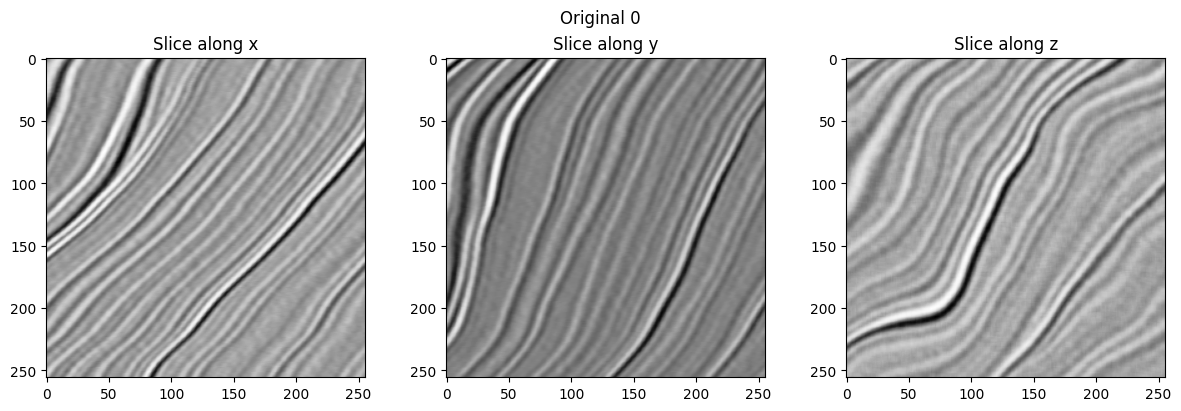

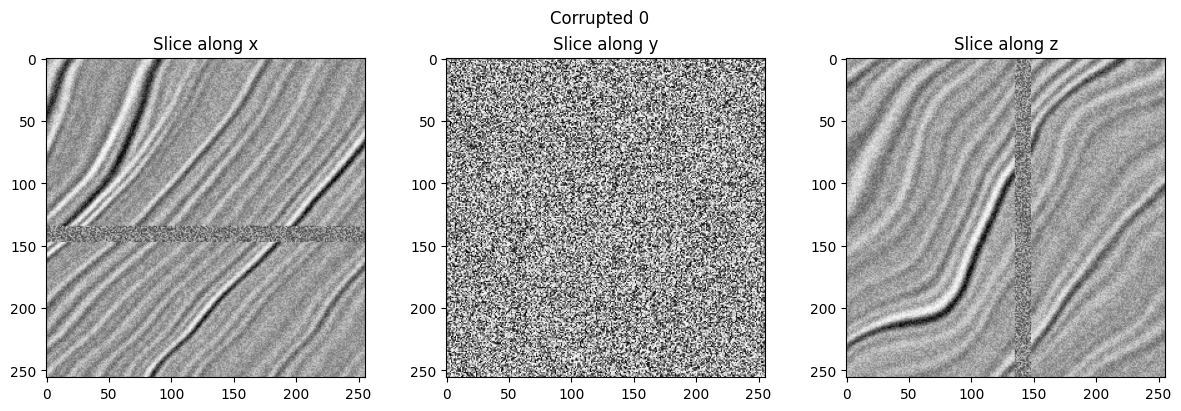

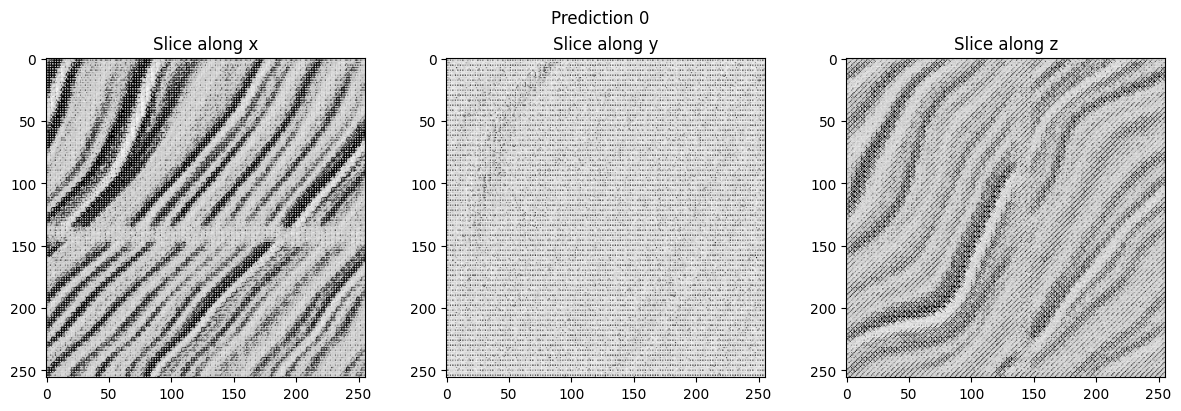

In [28]:
keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

train_loader = gan.train_dataloader()

for i, batch in enumerate(train_loader):
    prediction = gan(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)

In [24]:
gan_trained = GAN3D.load_from_checkpoint(TRAINING_DIR / '3DGAN-tce-loss/last.ckpt',
                                         target_data_dir=TARGET_DATA_DIR, percentile=5, n_critic=5, recon_loss=tce_loss)

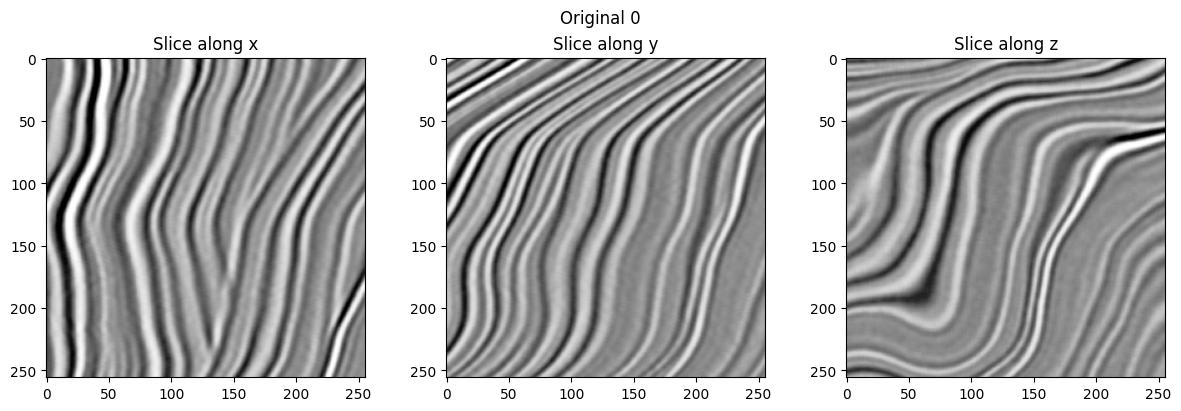

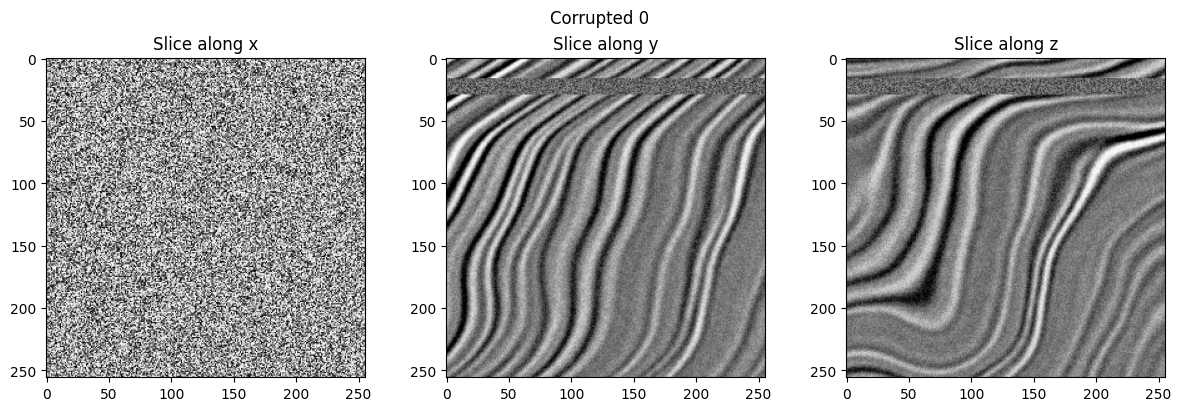

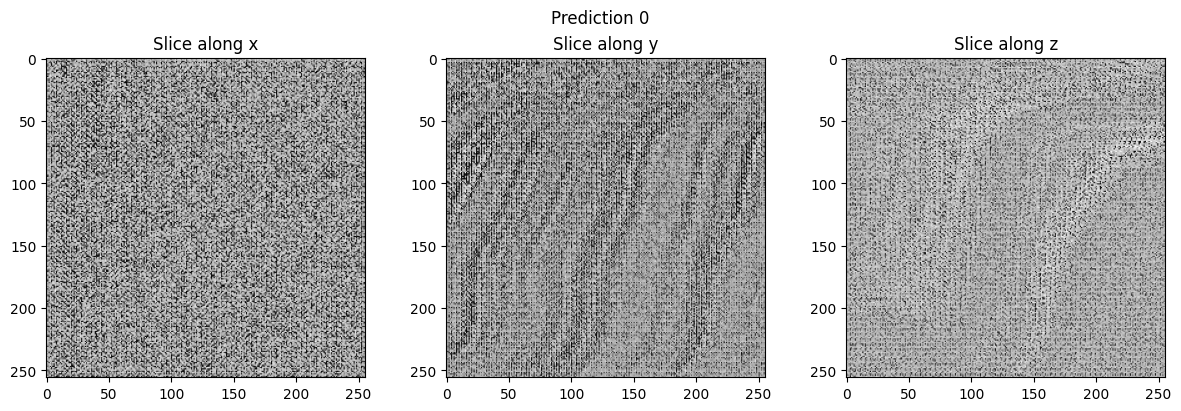

In [33]:
gan_trained.prepare_data()
train_loader = gan_trained.train_dataloader()

keys = ['target','image', 'prediction']
labels = ['Original','Corrupted', 'Prediction']

for i, batch in enumerate(train_loader):
    prediction = gan_trained(batch['image'])
    batch['prediction'] = prediction
    visualize_volumes(batch, i, keys, labels, True)

In [34]:
batch['prediction'][0, 0, 100, 200, :100]

metatensor([ 0.2771,  0.0901,  0.0072, -0.0925,  0.5695, -0.0658,  0.9819, -0.2066,
         0.7619,  0.1751,  0.6976,  0.2829,  0.8142, -0.1019,  0.4855, -0.0545,
         0.4196, -0.0662,  0.6355, -0.0322,  0.7074, -0.0430,  0.8551, -0.1258,
         0.6610,  0.1515,  0.8541, -0.1234,  0.7973,  0.3746,  0.9945, -0.2974,
        -0.0050, -0.0651,  0.8714, -0.0224,  0.4797, -0.0165,  0.4686,  0.7975,
         0.3453,  0.7939,  0.4054,  0.4686,  0.9374,  0.4407,  0.9170,  0.3606,
         0.3129, -0.1568,  0.2227,  0.5792,  0.9527,  0.1694,  0.5964, -0.1038,
         0.7450, -0.2490,  0.6031, -0.0829,  0.6078,  0.0794,  0.6224, -0.0123,
         0.4192, -0.1828,  0.6552,  0.2160,  0.9455, -0.0819,  0.6656,  0.4454,
         0.8519, -0.1737, -0.0118,  0.6983,  0.9472, -0.2019,  0.9185,  0.3687,
         0.8496, -0.1076,  0.4843, -0.0613,  0.3868, -0.2111,  0.9944, -0.3397,
         0.9668, -0.0761,  0.8493,  0.1212,  0.9677, -0.2310,  0.9397,  0.7505,
         0.8021, -0.3461,  0.9130, -

In [35]:
batch['prediction'].min()

metatensor(-0.9715, grad_fn=<AliasBackward0>)

In [36]:
batch['image'].min()

metatensor(-1.0000)

In [37]:
batch['image'][0, 0, 100, 200, :100]

metatensor([ 0.6814,  1.0000,  1.0000,  0.8225,  0.6445,  0.1909,  0.0198, -0.0595,
         0.0136, -0.1443, -0.0765, -0.0238, -0.1365, -0.0476,  0.0416, -0.1233,
        -0.0766,  0.0253,  0.0626, -0.0807, -0.0245,  0.0026,  0.0496,  0.0466,
         0.2389,  0.5361,  0.6632,  0.7768,  0.9815,  0.6890,  0.6729,  0.4525,
         0.1631,  0.0500,  0.0530, -0.3243, -0.3950, -0.1526, -0.0656,  0.2337,
         0.4118,  0.3808,  0.3660,  0.1194, -0.0061, -0.2758, -0.0804, -0.1493,
        -0.1604,  0.1218,  0.1341,  0.2992,  0.3982,  0.4143,  0.6977,  0.8078,
         0.6807,  0.5182,  0.3225,  0.2529,  0.0187,  0.2267,  0.1186,  0.2357,
         0.2505,  0.0859,  0.1222,  0.0047,  0.1779, -0.0261,  0.1466,  0.1316,
         0.0387, -0.1285, -0.2274, -0.2620, -0.0758, -0.0193,  0.1188,  0.3584,
         0.8194,  0.8790,  1.0000,  0.9674,  0.7541,  0.4177,  0.3054,  0.1622,
         0.1500, -0.0224,  0.0753,  0.0268, -0.1567, -0.2006, -0.2745, -0.2297,
        -0.1806, -0.1016, -0.0291,  

In [38]:
batch['prediction'][0, 0, 100, 200, :100] - batch['image'][0, 0, 100, 200, :100]

metatensor([-0.4042, -0.9099, -0.9928, -0.9151, -0.0751, -0.2567,  0.9621, -0.1471,
         0.7483,  0.3194,  0.7741,  0.3067,  0.9507, -0.0543,  0.4439,  0.0688,
         0.4963, -0.0915,  0.5729,  0.0485,  0.7320, -0.0456,  0.8054, -0.1724,
         0.4221, -0.3845,  0.1909, -0.9002, -0.1842, -0.3143,  0.3215, -0.7499,
        -0.1681, -0.1151,  0.8184,  0.3019,  0.8748,  0.1362,  0.5341,  0.5638,
        -0.0665,  0.4132,  0.0394,  0.3492,  0.9435,  0.7164,  0.9974,  0.5099,
         0.4733, -0.2786,  0.0886,  0.2801,  0.5545, -0.2449, -0.1013, -0.9116,
         0.0643, -0.7672,  0.2805, -0.3358,  0.5890, -0.1472,  0.5038, -0.2479,
         0.1687, -0.2687,  0.5330,  0.2113,  0.7676, -0.0558,  0.5190,  0.3138,
         0.8131, -0.0452,  0.2155,  0.9603,  1.0230, -0.1825,  0.7997,  0.0103,
         0.0302, -0.9865, -0.5157, -1.0287, -0.3673, -0.6288,  0.6890, -0.5020,
         0.8168, -0.0537,  0.7740,  0.0944,  1.1244, -0.0305,  1.2143,  0.9802,
         0.9827, -0.2445,  0.9421, -